## Automated anisotropic resistivity inversion for efficient formation evaluation and uncertainty quantification

### Misael M. Morales, Ali Eghbali, Oriyomi Raheem, Michael Pyrcz, Carlos Torres-Verdin
***
## Uncertainty Quantification: Gradient-Based and PINN Results
***

In [1]:
from main import *

check_torch()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
case1, case2, synthetic1, synthetic2 = load_all_data()


------------------------------------------------------------
----------------------- VERSION INFO -----------------------
Torch version: 2.1.2.post300 | Torch Built with CUDA? True
# Device(s) available: 1, Name(s): NVIDIA GeForce RTX 3080
------------------------------------------------------------

Name              : Source                : Shape
----------------- : --------------------- : -----------
Field Case 1      : (Chevron)             : (2399, 12)
Field Case 2      : (AkerBP)              : (11143, 12)
Synthetic Case 1  : (Laminated)           : (801, 14)
Synthetic Case 2  : (Laminated+Dispersed) : (415, 10)


***
Computational Speedups

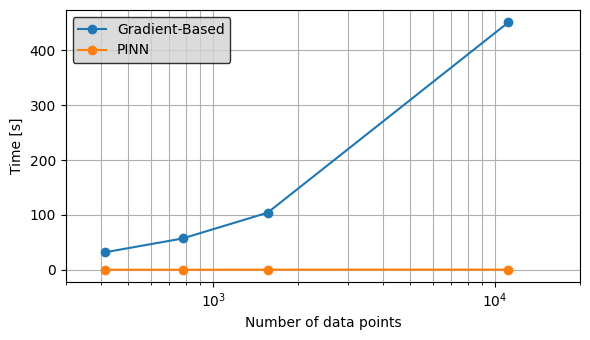

In [2]:
size_arr = np.array([415, 779, 1560, 11142])
gb_arr = np.array([32, 57, 104, 451])
pinn_arr = np.array([0.01, 0.05, 0.2, 0.3])

fig = plt.figure(figsize=(6,3.5))
ax1 = fig.add_subplot(111)
ax1.plot(size_arr, gb_arr, 'o-', label='Gradient-Based')
ax1.plot(size_arr, pinn_arr, 'o-', label='PINN')
ax1.set(xlim=[3e2, 2e4], xscale='log', 
       xlabel='Number of data points', ylabel='Time [s]')
ax1.legend(facecolor='lightgrey', edgecolor='k')
ax1.grid(True, which='both')
plt.tight_layout()
plt.show()

***
Uncertainty

In [3]:
class ResInvPINN(nn.Module):
    def __init__(self, hidden_dim:int=128, csh_constraint_mult=1.0):
        super(ResInvPINN, self).__init__()
        self.fc1  = nn.Linear(2, hidden_dim)
        self.fc2  = nn.Linear(hidden_dim, hidden_dim)
        self.fc3  = nn.Linear(hidden_dim, 2)
        self.mult = csh_constraint_mult

    def constraints(self, d):
        c, s = d[:, 0], d[:, 1]
        c = self.mult*torch.sigmoid(c)
        return torch.stack([c, s], dim=-1)
       
    def forward(self, x):
        x = x[:, :2]
        
        x = self.fc1(x)
        x = nn.Tanh()(x)

        x = self.fc2(x)
        x = nn.Tanhshrink()(x)

        x = self.fc3(x)
        x = self.constraints(x)

        return x

In [4]:
chevron_model      = ResInvPINN(hidden_dim=150).to(device)
chevron_model.load_state_dict(torch.load('models/model_Chevron.pth'))
chevron_results    = pd.read_csv('results/pinn_solution_Chevron.csv', index_col=0)
chevron_gb_results = pd.read_csv('results/gradient_based_solution_Chevron.csv', index_col=0)
chevron_data       = lasio.read('cases/well1.las').df().loc[chevron_results.index]
chevron_all        = chevron_data.merge(chevron_results).set_index(chevron_results.index)

akerbp_model       = ResInvPINN(hidden_dim=150).to(device)
akerbp_model.load_state_dict(torch.load('models/model_AkerBP.pth'))
akerbp_results     = pd.read_csv('results/pinn_solution_AkerBP.csv', index_col=0)
akerbp_gb_results  = pd.read_csv('results/gradient_based_solution_AkerBP.csv', index_col=0)
akerbp_data        = lasio.read('cases/well2.LAS').df().loc[akerbp_results.index]
akerbp_all         = akerbp_data.merge(akerbp_results).set_index(akerbp_results.index)

synth1_model       = ResInvPINN(hidden_dim=150).to(device)
synth1_model.load_state_dict(torch.load('models/model_synthetic1.pth'))
synth1_results     = pd.read_csv('results/pinn_solution_synthetic1.csv', index_col=0)
synth1_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic1.csv', index_col=0).iloc[22:]
synthetic1_data     = lasio.read('cases/Case1.las').df().join(lasio.read('cases/Case1_RvRh.las').df()).loc[synth1_results.index]
synthetic1_all     = synthetic1_data.merge(synth1_results, left_index=True, right_index=True)

synth2_model       = ResInvPINN(hidden_dim=150).to(device)
synth2_model.load_state_dict(torch.load('models/model_synthetic2.pth'))
synth2_results     = pd.read_csv('results/pinn_solution_synthetic2.csv', index_col=0)
synth2_gb_results  = pd.read_csv('results/gradient_based_solution_synthetic2.csv', index_col=0)
synthetic2_data    = lasio.read('cases/Case2.las').df().loc[synth2_results.index]
synthetic2_all     = synthetic2_data.merge(synth2_results).set_index(synth2_results.index)

***

In [5]:
n_realizations = 1000
noise_level = 0.05

In [6]:
chevron_uq = np.zeros((n_realizations, chevron_results.shape[0], 2))
for i in range(n_realizations):
    noisy_inputs = chevron_results[['Rv','Rh']] + noise_level*np.random.lognormal(0, 1, size=(chevron_results.shape[0], 2))
    noisy_inputs = torch.tensor(noisy_inputs.values, dtype=torch.float32).to(device)
    chevron_uq[i] = chevron_model(noisy_inputs).cpu().detach().numpy().squeeze()
print(chevron_uq.shape)

chevron_uq_csh = np.zeros((n_realizations, chevron_results.shape[0]))
for i in range(n_realizations):
    c = chevron_uq[i,:,0]
    chevron_uq_csh[i] = (c - c.min())/(c.max() - c.min())

chevron_uq_rss = chevron_uq[...,1]

(1000, 1560, 2)


In [7]:
akerbp_uq = np.zeros((n_realizations, akerbp_results.shape[0], 2))
for i in range(n_realizations):
    noisy_inputs = akerbp_results[['Rv','Rh']] + noise_level*np.random.lognormal(0, 1, size=(akerbp_results.shape[0], 2))
    noisy_inputs = torch.tensor(noisy_inputs.values, dtype=torch.float32).to(device)
    akerbp_uq[i] = akerbp_model(noisy_inputs).cpu().detach().numpy().squeeze()
print(akerbp_uq.shape)

akerbp_uq_csh = np.zeros((n_realizations, akerbp_results.shape[0]))
for i in range(n_realizations):
    c = akerbp_uq[i,:,0]
    akerbp_uq_csh[i] = (c - c.min())/(c.max() - c.min())

akerbp_uq_rss = akerbp_uq[...,1]

(1000, 11142, 2)


In [8]:
synthetic1_uq = np.zeros((n_realizations, synth1_results.shape[0], 2))
for i in range(n_realizations):
    noisy_inputs = synth1_results[['Rv','Rh']] + noise_level*np.random.lognormal(0, 1, size=(synth1_results.shape[0], 2))
    noisy_inputs = torch.tensor(noisy_inputs.values, dtype=torch.float32).to(device)
    synthetic1_uq[i] = synth1_model(noisy_inputs).cpu().detach().numpy().squeeze()
print(synthetic1_uq.shape)

synthetic1_uq_csh = np.zeros((n_realizations, synth1_results.shape[0]))
for i in range(n_realizations):
    c = synthetic1_uq[i,:,0]
    synthetic1_uq_csh[i] = (c - c.min())/(c.max() - c.min())

synthetic1_uq_rss = synthetic1_uq[...,1]

(1000, 779, 2)


In [9]:
synthetic2_uq = np.zeros((n_realizations, synth2_results.shape[0], 2))
for i in range(n_realizations):
    noisy_inputs = synth2_results[['Rv','Rh']] + noise_level*np.random.lognormal(0, 1, size=(synth2_results.shape[0], 2))
    noisy_inputs = torch.tensor(noisy_inputs.values, dtype=torch.float32).to(device)
    synthetic2_uq[i] = synth2_model(noisy_inputs).cpu().detach().numpy().squeeze()
print(synthetic2_uq.shape)

synthetic2_uq_csh = np.zeros((n_realizations, synth2_results.shape[0]))
for i in range(n_realizations):
    c = synthetic2_uq[i,:,0]
    synthetic2_uq_csh[i] = (c - c.min())/(c.max() - c.min())

synthetic2_uq_rss = synthetic2_uq[...,1]

(1000, 415, 2)


In [10]:
chevron_uq_rv = chevron_uq_csh*chevron_all['Rvsh'].iloc[0] + (1-chevron_uq_csh)*chevron_uq_rss
chevron_uq_rh = chevron_uq_csh/chevron_all['Rhsh'].iloc[0] + (1-chevron_uq_csh)/chevron_uq_rss

akerbp_uq_rv = akerbp_uq_csh*akerbp_all['Rvsh'].iloc[0] + (1-akerbp_uq_csh)*akerbp_uq_rss
akerbp_uq_rh = akerbp_uq_csh/akerbp_all['Rhsh'].iloc[0] + (1-akerbp_uq_csh)/akerbp_uq_rss

synthetic1_uq_rv = synthetic1_uq_csh*synthetic1_all['Rvsh'].iloc[0] + (1-synthetic1_uq_csh)*synthetic1_uq_rss
synthetic1_uq_rh = synthetic1_uq_csh/synthetic1_all['Rhsh'].iloc[0] + (1-synthetic1_uq_csh)/synthetic1_uq_rss

synthetic2_uq_rv = synthetic2_uq_csh*synthetic2_all['Rvsh'].iloc[0] + (1-synthetic2_uq_csh)*synthetic2_uq_rss
synthetic2_uq_rh = synthetic2_uq_csh/synthetic2_all['Rhsh'].iloc[0] + (1-synthetic2_uq_csh)/synthetic2_uq_rss

In [36]:
np.mean(np.percentile(akerbp_uq_rh, 90, axis=0) - np.percentile(akerbp_uq_rh, 10, axis=0))

0.12319619022291754

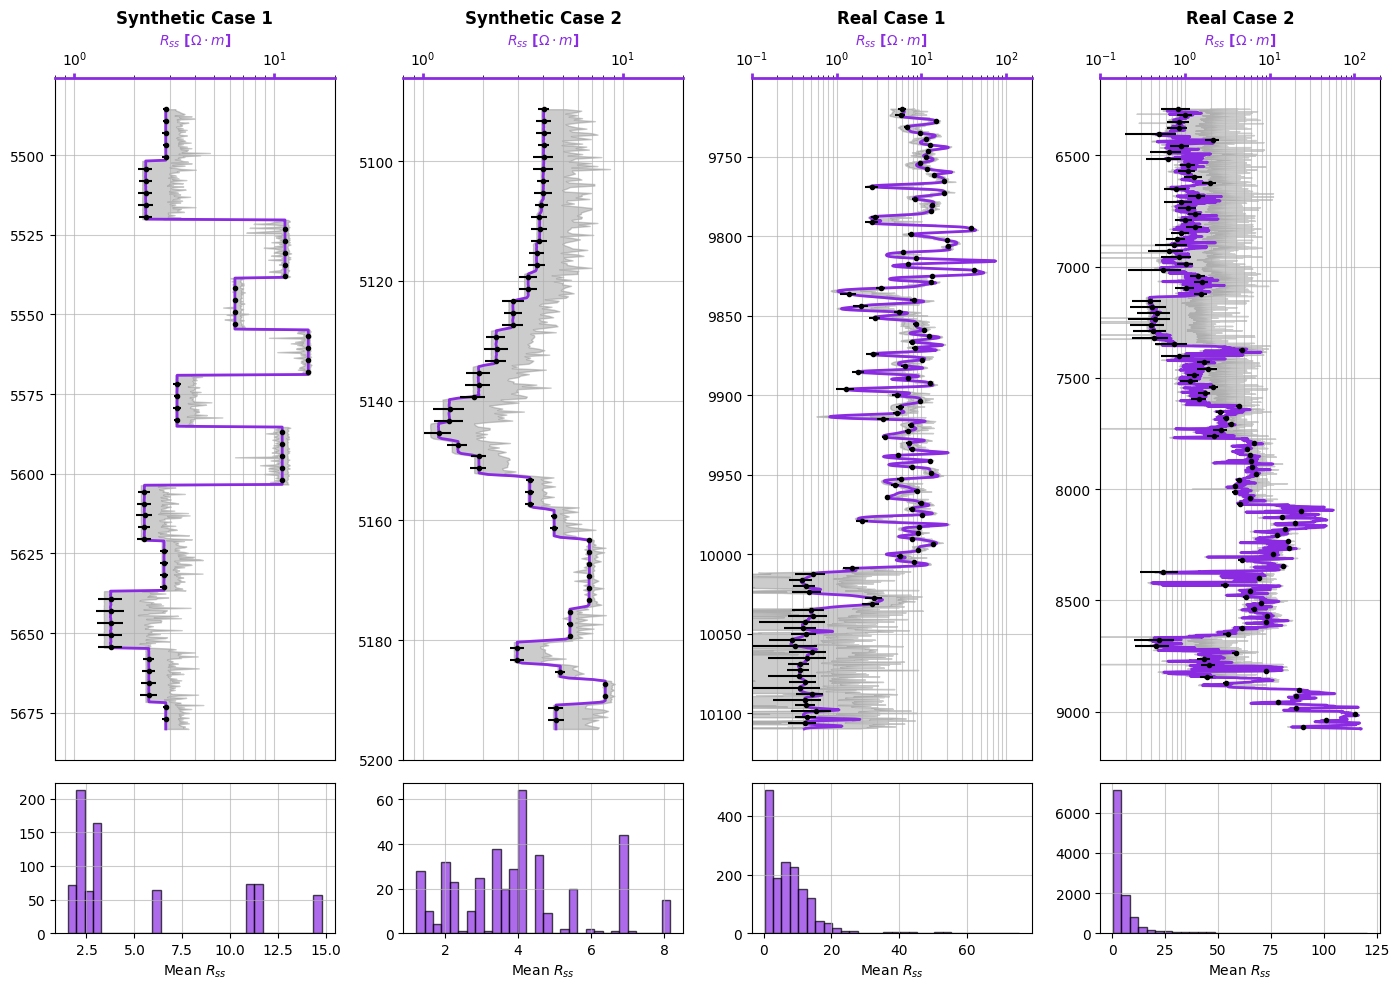

In [100]:
fig, axs = plt.subplots(2, 4, figsize=(14,10), height_ratios=[1.5, 0.33])
c = 'blueviolet'
val = 'Rss_pred'
lab = '$R_{ss}$'
sl = True
u = '$\Omega\cdot m$'
l1, l2, l3, l4 = [0.8e0, 2e1], [0.8e0, 2e1], [1e-1, 2e2], [1e-1, 2e2]
#l1, l2, l3, l4 = [-0.05, 1.05], [-0.05, 1.05], [-0.05, 1.05], [-0.05, 1.05]

q1 = synthetic1_uq_rss
q2 = synthetic2_uq_rss
q3 = chevron_uq_rss
q4 = akerbp_uq_rss

plot_uq(axs[0,0], synthetic1_all, q1, title='Synthetic Case 1', semilog=sl, xlim=l1,
            eb_sampling=50, color=c, xlabel=lab, units=u)

plot_uq(axs[0,1], synthetic2_all, q2, title='Synthetic Case 2', semilog=sl, xlim=l2,
            eb_sampling=50, color=c, xlabel=lab, units=u)

plot_uq(axs[0,2], chevron_all, q3, title='Real Case 1', semilog=sl, xlim=l3,
            eb_sampling=100, color=c, xlabel=lab, units=u)

plot_uq(axs[0,3], akerbp_all, q4, title='Real Case 2', semilog=sl, xlim=l4,            
                eb_sampling=100, color=c, xlabel=lab, units=u)


hist_uq(axs[1,0], q1, color=c, label=lab)
hist_uq(axs[1,1], q2, color=c, label=lab)
hist_uq(axs[1,2], q3, color=c, label=lab)
hist_uq(axs[1,3], q4, color=c, label=lab)

plt.tight_layout()
plt.show()

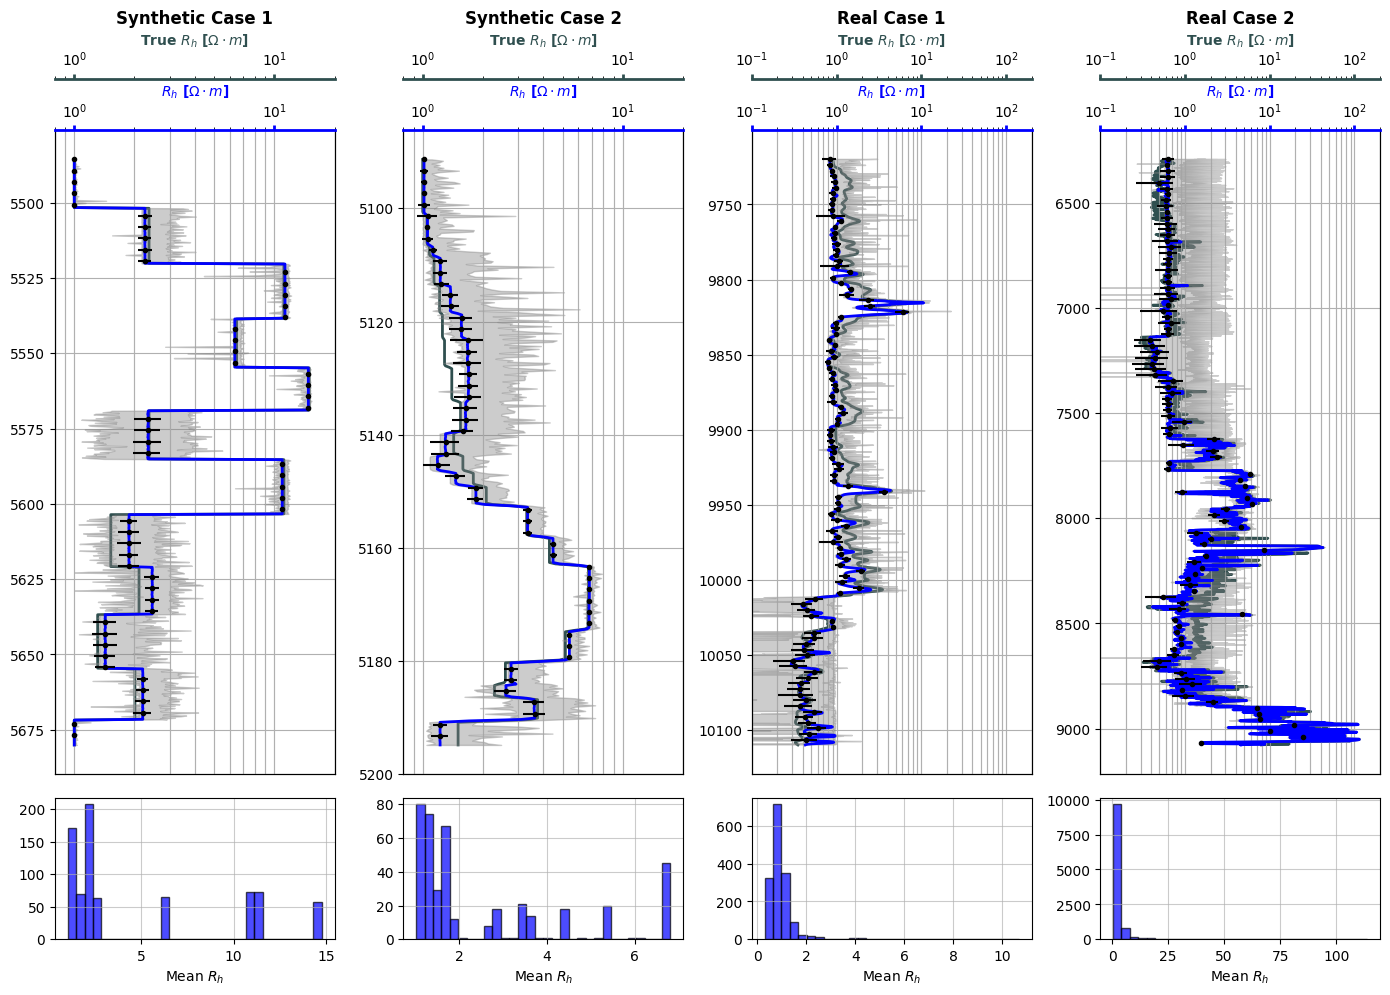

In [103]:
fig, axs = plt.subplots(2, 4, figsize=(14,10), height_ratios=[1.5, 0.33])
c = 'b'
val = 'Rh'
lab = '$R_{h}$'
sl = True
u = '$\Omega\cdot m$'
l1, l2, l3, l4 = [0.8e0, 2e1], [0.8e0, 2e1], [1e-1, 2e2], [1e-1, 2e2]

q1 = 1/synthetic1_uq_rh
q2 = 1/synthetic2_uq_rh
q3 = 1/chevron_uq_rh
q4 = 1/akerbp_uq_rh

ax0b = axs[0,0].twiny()
plot_uq(ax0b, synthetic1_all, q1, title='Synthetic Case 1', semilog=sl, xlim=l1,
            eb_sampling=50, color=c, xlabel=lab, units=u)
plot_curve(axs[0,0], synthetic1_all, val, lb=l1[0], ub=l1[1], color='darkslategray', 
              label='True {}'.format(lab), units=u, semilog=sl, pad=8)

ax1b = axs[0,1].twiny()
plot_uq(ax1b, synthetic2_all, q2, title='Synthetic Case 2', semilog=sl, xlim=l2,
            eb_sampling=50, color=c, xlabel=lab, units=u)
plot_curve(axs[0,1], synthetic2_all, val, lb=l2[0], ub=l2[1], color='darkslategray',
              label='True {}'.format(lab), units=u, semilog=sl, pad=8)

ax2b = axs[0,2].twiny()
plot_uq(ax2b, chevron_all, q3, title='Real Case 1', semilog=sl, xlim=l3,
            eb_sampling=100, color=c, xlabel=lab, units=u)
plot_curve(axs[0,2], chevron_all, val, lb=l3[0], ub=l3[1], color='darkslategray',
              label='True {}'.format(lab), units=u, semilog=sl, pad=8)

ax3b = axs[0,3].twiny()
plot_uq(ax3b, akerbp_all, q4, title='Real Case 2', semilog=sl, xlim=l4,            
                eb_sampling=100, color=c, xlabel=lab, units=u)
plot_curve(axs[0,3], akerbp_all, val, lb=l4[0], ub=l4[1], color='darkslategray',
                label='True {}'.format(lab), units=u, semilog=sl, pad=8)

hist_uq(axs[1,0], q1, color=c, label=lab)
hist_uq(axs[1,1], q2, color=c, label=lab)
hist_uq(axs[1,2], q3, color=c, label=lab)
hist_uq(axs[1,3], q4, color=c, label=lab)

plt.tight_layout()
plt.show()

***

In [ ]:
titles = ['Chevron2009', 'AkerBP Hanz Prospect', 'Synthetic Case 1', 'Synthetic Case 2']

fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs

for i in range(n_realizations):
    ax1.plot(chevron_uq_csh[i], chevron_results.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_uq_csh[i], akerbp_results.index, color='gray', alpha=0.1)
    ax3.plot(synthetic1_uq_csh[i], synth1_results.index, color='gray', alpha=0.1)
    ax4.plot(synthetic2_uq_csh[i], synth2_results.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Csh_pred'], chevron_results.index, color='red')
ax2.plot(akerbp_results['Csh_pred'], akerbp_results.index, color='red')
ax3.plot(synth1_results['Csh_pred'], synth1_results.index, color='red')
ax4.plot(synth2_results['Csh_pred'], synth2_results.index, color='red')

[ax.set(title=titles[i], xlabel='$C_{sh}$', ylabel='Depth [ft]', xlim=(-0.05,1.05)) for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
titles = ['Chevron2009', 'AkerBP Hanz Prospect', 'Synthetic Case 1', 'Synthetic Case 2']

fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs

for i in range(n_realizations):
    ax1.plot(chevron_uq[i,:,1], chevron_results.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_uq[i,:,1], akerbp_results.index, color='gray', alpha=0.1)
    ax3.plot(synthetic1_uq[i,:,1], synth1_results.index, color='gray', alpha=0.1)
    ax4.plot(synthetic2_uq[i,:,1], synth2_results.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Rss_pred'], chevron_results.index, color='b')
ax2.plot(akerbp_results['Rss_pred'], akerbp_results.index, color='b')
ax3.plot(synth1_results['Rss_pred'], synth1_results.index, color='b')
ax4.plot(synth2_results['Rss_pred'], synth2_results.index, color='b')

[ax.set(title=titles[i], xlabel='$R_{ss}$', ylabel='Depth [ft]', xscale='log') for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

***

In [ ]:
titles = ['Chevron2009', 'AkerBP Hanz Prospect', 'Synthetic Case 1', 'Synthetic Case 2']

fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs

for i in range(n_realizations):
    ax1.plot(chevron_uq[i,:,1], chevron_results.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_uq[i,:,1], akerbp_results.index, color='gray', alpha=0.1)
    ax3.plot(synthetic1_uq[i,:,1], synth1_results.index, color='gray', alpha=0.1)
    ax4.plot(synthetic2_uq[i,:,1], synth2_results.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Rss_pred'], chevron_results.index, color='b')
ax2.plot(akerbp_results['Rss_pred'], akerbp_results.index, color='b')
ax3.plot(synth1_results['Rss_pred'], synth1_results.index, color='b')
ax4.plot(synth2_results['Rss_pred'], synth2_results.index, color='b')

[ax.set(title=titles[i], xlabel='$R_{ss}$', ylabel='Depth [ft]', xscale='log') for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(14,7))
ax1, ax2, ax3, ax4 = axs[0]
ax5, ax6, ax7, ax8 = axs[1]

ax1.hist(chevron_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax2.hist(akerbp_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax3.hist(synth1_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax4.hist(synth2_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
[ax.grid(True, which='both', alpha=0.5) for ax in axs[0]]
[ax.set(xlabel='$U(C_{sh})$', ylabel='Frequency', title=titles[i]) for i, ax in enumerate(axs[0])]

ax5.hist(chevron_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax6.hist(akerbp_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax7.hist(synth1_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax8.hist(synth2_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
[ax.grid(True, which='both', alpha=0.5) for ax in axs[1]]
[ax.set(xlabel='$U(R_{ss})$', ylabel='Frequency') for ax in axs[1]]

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs
titles = ['Chevron2009', 'AkerBP', 'Synthetic Case 1', 'Synthetic Case 2']

for i in range(n_realizations):
    csh_chevron, rss_chevron = chevron_uq[i, :, 0], chevron_uq[i, :, 1]
    rvsh_chevron, rhsh_chevron = chevron_results['Rvsh'].values, chevron_results['Rhsh'].values
    rv_chevron = csh_chevron*rvsh_chevron + (1-csh_chevron)*rss_chevron
    rh_chevron = 1/(csh_chevron/rhsh_chevron + (1-csh_chevron)/rss_chevron)

    csh_akerbp, rss_akerbp = akerbp_uq[i, :, 0], akerbp_uq[i, :, 1]
    rvsh_akerbp, rhsh_akerbp = akerbp_results['Rvsh'].values, akerbp_results['Rhsh'].values
    rv_akerbp = csh_akerbp*rvsh_akerbp + (1-csh_akerbp)*rss_akerbp
    rh_akerbp = 1/(csh_akerbp/rhsh_akerbp + (1-csh_akerbp)/rss_akerbp)

    csh_synth1, rss_synth1 = synthetic1_uq[i, :, 0], synthetic1_uq[i, :, 1]
    rvsh_synth1, rhsh_synth1 = synth1_results['Rvsh'].values, synth1_results['Rhsh'].values
    rv_synth1 = csh_synth1*rvsh_synth1 + (1-csh_synth1)*rss_synth1
    rh_synth1 = 1/(csh_synth1/rhsh_synth1 + (1-csh_synth1)/rss_synth1)

    csh_synth2, rss_synth2 = synthetic2_uq[i, :, 0], synthetic2_uq[i, :, 1]
    rvsh_synth2, rhsh_synth2 = synth2_results['Rvsh'].values, synth2_results['Rhsh'].values
    rv_synth2 = csh_synth2*rvsh_synth2 + (1-csh_synth2)*rss_synth2
    rh_synth2 = 1/(csh_synth2/rhsh_synth2 + (1-csh_synth2)/rss_synth2)
    
    ax1.plot(rv_chevron, chevron_results.index, c='rosybrown', alpha=0.1)
    ax1.plot(rh_chevron, chevron_results.index, c='lightsteelblue', alpha=0.1)

    ax2.plot(rv_akerbp, akerbp_results.index, c='rosybrown', alpha=0.1)
    ax2.plot(rh_akerbp, akerbp_results.index, c='lightsteelblue', alpha=0.1)

    ax3.plot(rv_synth1, synth1_results.index, c='rosybrown', alpha=0.1)
    ax3.plot(rh_synth1, synth1_results.index, c='lightsteelblue', alpha=0.1)

    ax4.plot(rv_synth2, synth2_results.index, c='rosybrown', alpha=0.1)
    ax4.plot(rh_synth2, synth2_results.index, c='lightsteelblue', alpha=0.1)

ax1.plot(chevron_results['Rv'], chevron_results.index, c='k', lw=1, ls='--')
ax1.plot(chevron_results['Rh'], chevron_results.index, c='k', lw=1, ls='-.')

ax2.plot(akerbp_results['Rv'], akerbp_results.index, c='k', lw=1, ls='--')
ax2.plot(akerbp_results['Rh'], akerbp_results.index, c='k', lw=1, ls='-.')

ax3.plot(synth1_results['Rv'], synth1_results.index, c='k', lw=1, ls='--')
ax3.plot(synth1_results['Rh'], synth1_results.index, c='k', lw=1, ls='-.')

ax4.plot(synth2_results['Rv'], synth2_results.index, c='k', lw=1, ls='--')
ax4.plot(synth2_results['Rh'], synth2_results.index, c='k', lw=1, ls='-.')

[ax.set_title(titles[i]) for i, ax in enumerate(axs)]
[ax.set(xscale='log', ylabel='Depth [ft]', xlabel='$R$ $[\Omega\cdot m]$', xlim=(1e-2, 1e2)) for ax in axs]
[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis(); ax2.invert_yaxis()
plt.tight_layout()
plt.show()

### Quadratic inversion, uncertainty quantification

In [ ]:
n_realizations = 100

chevron_q_uq = np.zeros((n_realizations, data1.shape[0], 2))
for i in tqdm(range(n_realizations)):
    rv, rh, rvsh, rhsh = data1['Rv'], data1['Rh'], data1['Rvsh'], data1['Rhsh']
    inputs = np.array([rv, rh]).T
    noisy_inputs = inputs + noise_level*np.random.lognormal(0, 1, size=(inputs.shape[0], 2))
    noisy_data   = np.concatenate([noisy_inputs, np.array([rvsh, rhsh]).T], axis=1)
    chevron_q_uq[i] = newton_inversion(pd.DataFrame(noisy_data, columns=[['Rv','Rh','Rvsh','Rhsh']]))

akerbp_q_uq = np.zeros((n_realizations, data2.shape[0], 2))
for i in tqdm(range(n_realizations)):
    rv, rh, rvsh, rhsh = data2['Rv'], data2['Rh'], data2['Rvsh'], data2['Rhsh']
    inputs = np.array([rv, rh]).T
    noisy_inputs = inputs + noise_level*np.random.lognormal(0, 1, size=(inputs.shape[0], 2))
    noisy_data   = np.concatenate([noisy_inputs, np.array([rvsh, rhsh]).T], axis=1)
    akerbp_q_uq[i] = newton_inversion(pd.DataFrame(noisy_data, columns=[['Rv','Rh','Rvsh','Rhsh']]))

synth1_q_uq = np.zeros((n_realizations, data3.shape[0], 2))
for i in tqdm(range(n_realizations)):
    rv, rh, rvsh, rhsh = data3['Rv'], data3['Rh'], data3['Rvsh'], data3['Rhsh']
    inputs = np.array([rv, rh]).T
    noisy_inputs = inputs + noise_level*np.random.lognormal(0, 1, size=(inputs.shape[0], 2))
    noisy_data   = np.concatenate([noisy_inputs, np.array([rvsh, rhsh]).T], axis=1)
    synth1_q_uq[i] = newton_inversion(pd.DataFrame(noisy_data, columns=[['Rv','Rh','Rvsh','Rhsh']]))

synth2_q_uq = np.zeros((n_realizations, data4.shape[0], 2))
for i in tqdm(range(n_realizations)):
    rv, rh, rvsh, rhsh = data4['Rv'], data4['Rh'], data4['Rvsh'], data4['Rhsh']
    inputs = np.array([rv, rh]).T
    noisy_inputs = inputs + noise_level*np.random.lognormal(0, 1, size=(inputs.shape[0], 2))
    noisy_data   = np.concatenate([noisy_inputs, np.array([rvsh, rhsh]).T], axis=1)
    synth2_q_uq[i] = newton_inversion(pd.DataFrame(noisy_data, columns=[['Rv','Rh','Rvsh','Rhsh']]))

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs
titles = ['Chevron2009', 'AkerBP', 'Synthetic Case 1', 'Synthetic Case 2']

for i in range(n_realizations):
    ax1.plot(chevron_q_uq[i,:,0], data1.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_q_uq[i,:,0], data2.index, color='gray', alpha=0.1)
    ax3.plot(synth1_q_uq[i,:,0], data3.index, color='gray', alpha=0.1)
    ax4.plot(synth2_q_uq[i,:,0], data4.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Csh_q'], chevron_results.index, color='red')
ax2.plot(akerbp_results['Csh_q'], akerbp_results.index, color='red')
ax3.plot(synth1_results['Csh_q'], synth1_results.index, color='red')
ax4.plot(synth2_results['Csh_q'], synth2_results.index, color='red')

[ax.set(title=titles[i], xlabel='$C_{sh}$', ylabel='Depth [ft]') for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs

for i in range(n_realizations):
    ax1.plot(chevron_q_uq[i,:,1], data1.index, color='gray', alpha=0.1)
    ax2.plot(akerbp_q_uq[i,:,1], data2.index, color='gray', alpha=0.1)
    ax3.plot(synth1_q_uq[i,:,1], data3.index, color='gray', alpha=0.1)
    ax4.plot(synth2_q_uq[i,:,1], data4.index, color='gray', alpha=0.1)

ax1.plot(chevron_results['Rss_q'], chevron_results.index, color='blue')
ax2.plot(akerbp_results['Rss_q'], akerbp_results.index, color='blue')
ax3.plot(synth1_results['Rss_q'], synth1_results.index, color='blue')
ax4.plot(synth2_results['Rss_q'], synth2_results.index, color='blue')

[ax.set(title=titles[i], xlabel='$R_{ss}$', ylabel='Depth [ft]', xscale='log') for i, ax in enumerate(axs)]
[ax.invert_yaxis() for ax in axs]
[ax.grid(True, which='both', alpha=0.5) for ax in axs]
plt.tight_layout()
plt.show()

In [ ]:
chevron_q_csh_range, chevron_q_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(chevron_q_uq[i,:,0], 10), np.percentile(chevron_q_uq[i,:,0], 90)
    p10_rss, p90_rss = np.percentile(chevron_q_uq[i,:,1], 10), np.percentile(chevron_q_uq[i,:,1], 90)
    chevron_q_csh_range.append(p90_csh - p10_csh)
    chevron_q_rss_range.append(p90_rss - p10_rss)
chevron_q_csh_range, chevron_q_rss_range = np.array(chevron_q_csh_range), np.array(chevron_q_rss_range)

akerbp_q_csh_range, akerbp_q_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(akerbp_q_uq[i,:,0], 10), np.percentile(akerbp_q_uq[i,:,0], 90)
    p10_rss, p90_rss = np.percentile(akerbp_q_uq[i,:,1], 10), np.percentile(akerbp_q_uq[i,:,1], 90)
    akerbp_q_csh_range.append(p90_csh - p10_csh)
    akerbp_q_rss_range.append(p90_rss - p10_rss)
akerbp_q_csh_range, akerbp_q_rss_range = np.array(akerbp_q_csh_range), np.array(akerbp_q_rss_range)

synth1_q_csh_range, synth1_q_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(synth1_q_uq[i,:,0], 10), np.percentile(synth1_q_uq[i,:,0], 90)
    p10_rss, p90_rss = np.percentile(synth1_q_uq[i,:,1], 10), np.percentile(synth1_q_uq[i,:,1], 90)
    synth1_q_csh_range.append(p90_csh - p10_csh)
    synth1_q_rss_range.append(p90_rss - p10_rss)
synth1_q_csh_range, synth1_q_rss_range = np.array(synth1_q_csh_range), np.array(synth1_q_rss_range)

synth2_q_csh_range, synth2_q_rss_range = [], []
for i in range(n_realizations):
    p10_csh, p90_csh = np.percentile(synth2_q_uq[i,:,0], 10), np.percentile(synth2_q_uq[i,:,0], 90)
    p10_rss, p90_rss = np.percentile(synth2_q_uq[i,:,1], 10), np.percentile(synth2_q_uq[i,:,1], 90)
    synth2_q_csh_range.append(p90_csh - p10_csh)
    synth2_q_rss_range.append(p90_rss - p10_rss)
synth2_q_csh_range, synth2_q_rss_range = np.array(synth2_q_csh_range), np.array(synth2_q_rss_range)

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(14,7))
ax1, ax2, ax3, ax4 = axs[0]
ax5, ax6, ax7, ax8 = axs[1]

ax1.hist(chevron_q_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax2.hist(akerbp_q_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax3.hist(synth1_q_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
ax4.hist(synth2_q_csh_range, bins=20, color='firebrick', alpha=0.75, edgecolor='gray')
[ax.grid(True, which='both', alpha=0.5) for ax in axs[0]]
[ax.set(xlabel='$U(C_{sh})$', ylabel='Frequency', title=titles[i]) for i, ax in enumerate(axs[0])]

ax5.hist(chevron_q_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax6.hist(akerbp_q_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax7.hist(synth1_q_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
ax8.hist(synth2_q_rss_range, bins=20, color='dodgerblue', alpha=0.75, edgecolor='gray')
[ax.grid(True, which='both', alpha=0.5) for ax in axs[1]]
[ax.set(xlabel='$U(R_{ss})$', ylabel='Frequency') for ax in axs[1]]

plt.tight_layout()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(14,8))
ax1, ax2, ax3, ax4 = axs
titles = ['Chevron2009', 'AkerBP', 'Synthetic Case 1', 'Synthetic Case 2']

for i in range(n_realizations):
    csh_chevron, rss_chevron = chevron_q_uq[i, :, 0], chevron_q_uq[i, :, 1]
    rvsh_chevron, rhsh_chevron = chevron_results['Rvsh'].values, chevron_results['Rhsh'].values
    rv_chevron = csh_chevron*rvsh_chevron + (1-csh_chevron)*rss_chevron
    rh_chevron = 1/(csh_chevron/rhsh_chevron + (1-csh_chevron)/rss_chevron)

    csh_akerbp, rss_akerbp = akerbp_q_uq[i, :, 0], akerbp_q_uq[i, :, 1]
    rvsh_akerbp, rhsh_akerbp = akerbp_results['Rvsh'].values, akerbp_results['Rhsh'].values
    rv_akerbp = csh_akerbp*rvsh_akerbp + (1-csh_akerbp)*rss_akerbp
    rh_akerbp = 1/(csh_akerbp/rhsh_akerbp + (1-csh_akerbp)/rss_akerbp)

    csh_synth1, rss_synth1 = synth1_q_uq[i, :, 0], synth1_q_uq[i, :, 1]
    rvsh_synth1, rhsh_synth1 = synth1_results['Rvsh'].values, synth1_results['Rhsh'].values
    rv_synth1 = csh_synth1*rvsh_synth1 + (1-csh_synth1)*rss_synth1
    rh_synth1 = 1/(csh_synth1/rhsh_synth1 + (1-csh_synth1)/rss_synth1)

    csh_synth2, rss_synth2 = synth2_q_uq[i, :, 0], synth2_q_uq[i, :, 1]
    rvsh_synth2, rhsh_synth2 = synth2_results['Rvsh'].values, synth2_results['Rhsh'].values
    rv_synth2 = csh_synth2*rvsh_synth2 + (1-csh_synth2)*rss_synth2
    rh_synth2 = 1/(csh_synth2/rhsh_synth2 + (1-csh_synth2)/rss_synth2)
    
    ax1.plot(rv_chevron, chevron_results.index, c='rosybrown', alpha=0.1)
    ax1.plot(rh_chevron, chevron_results.index, c='lightsteelblue', alpha=0.1)

    ax2.plot(rv_akerbp, akerbp_results.index, c='rosybrown', alpha=0.1)
    ax2.plot(rh_akerbp, akerbp_results.index, c='lightsteelblue', alpha=0.1)

    ax3.plot(rv_synth1, synth1_results.index, c='rosybrown', alpha=0.1)
    ax3.plot(rh_synth1, synth1_results.index, c='lightsteelblue', alpha=0.1)

    ax4.plot(rv_synth2, synth2_results.index, c='rosybrown', alpha=0.1)
    ax4.plot(rh_synth2, synth2_results.index, c='lightsteelblue', alpha=0.1)

ax1.plot(chevron_results['Rv'], chevron_results.index, c='k', lw=1, ls='--')
ax1.plot(chevron_results['Rh'], chevron_results.index, c='k', lw=1, ls='-.')

ax2.plot(akerbp_results['Rv'], akerbp_results.index, c='k', lw=1, ls='--')
ax2.plot(akerbp_results['Rh'], akerbp_results.index, c='k', lw=1, ls='-.')

ax3.plot(synth1_results['Rv'], synth1_results.index, c='k', lw=1, ls='--')
ax3.plot(synth1_results['Rh'], synth1_results.index, c='k', lw=1, ls='-.')

ax4.plot(synth2_results['Rv'], synth2_results.index, c='k', lw=1, ls='--')
ax4.plot(synth2_results['Rh'], synth2_results.index, c='k', lw=1, ls='-.')

[ax.set_title(titles[i]) for i, ax in enumerate(axs)]
[ax.set(xscale='log', ylabel='Depth [ft]', xlabel='$R$ $[\Omega\cdot m]$', xlim=(1e-2, 1e2)) for ax in axs]
[ax.grid(True, which='both') for ax in axs]
ax1.invert_yaxis(); ax2.invert_yaxis()
plt.tight_layout()
plt.show()

***
# END